# MLP for Sine Wave Prediction
## MSE23185 - Tran Trong Hieu
## Excercise 1: Build a 3-layer MLP for Sine Wave Prediction with a following configurations:
- Using Xavier weight initialization
- Using activation function in hidden layers: ReLU
- Using number of neurons in each layer: 100; 200
- Using loss function : MSE
- Optimizer: SGD

In [ ]:
# Import
import numpy as np
import matplotlib.pyplot as plt

# Generate sine wave data
np.random.seed(42)
X = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(-1, 1) # Input feature
y = np.sin(X) + 0.1 * np.random.randn(*X.shape) # Target with some noise

# Define the ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Define the derivative of the ReLU function
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Mean Squared Error loss function
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Derivative of MSE with respect to prediction
def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

## 1. Number of neurons in each layer: 100

Epoch 0, Loss: 6.8722465950036655
Epoch 1000, Loss: 0.6382139691611198
Epoch 2000, Loss: 0.5419601955255008
Epoch 3000, Loss: 0.46957347638018554
Epoch 4000, Loss: 0.41280655198510524
Epoch 5000, Loss: 0.36502179386333516
Epoch 6000, Loss: 0.3209443951228332
Epoch 7000, Loss: 0.2780905836497362
Epoch 8000, Loss: 0.2461473172713498
Epoch 9000, Loss: 0.22567474081662786


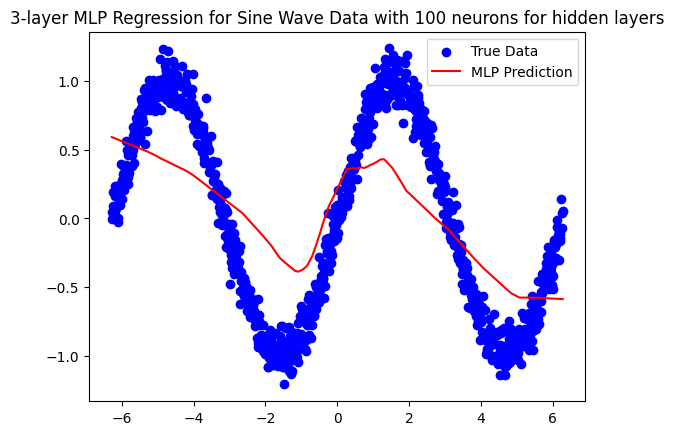

In [ ]:
# Initialize weights and biases
def initialize_parameters(input_size, hidden_size, output_size, num_hidden_layers = 2):
    parameters = {}
    parameters['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(1 / input_size)
    parameters['b1'] = np.random.randn(1, hidden_size)

    for i in range(2, num_hidden_layers + 1):
        parameters[f'W{i}'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(1 / hidden_size)
        parameters[f'b{i}'] = np.random.randn(1, hidden_size)

    parameters[f'W{num_hidden_layers + 1}'] = np.random.randn(hidden_size, output_size) * np.sqrt(1 / hidden_size)
    parameters[f'b{num_hidden_layers + 1}'] = np.random.randn(1, output_size)

    return parameters

# Forward pass
def forward(X, parameters, num_hidden_layers = 2):
    cache = {}

    A = X

    for i in range(1, num_hidden_layers + 1):
        Z = np.dot(A, parameters[f'W{i}']) + parameters[f'b{i}']
        A = relu(Z)
        cache[f'Z{i}'] = Z
        cache[f'A{i}'] = A

    # Output layer (linear function)
    Z_output = np.dot(A, parameters[f'W{num_hidden_layers + 1}']) + parameters[f'b{num_hidden_layers + 1}']
    cache[f'Z{num_hidden_layers + 1}'] = Z_output

    return Z_output, cache

# Backward pass (Stochastic Gardient Descent)
def backward(X, y, parameters, cache, velocities, num_hidden_layers = 2, learning_rate = 0.001, momentum = 0.9):
    m = y.size
    grads = {}

    # Gradient of loss w.r.t. output (Z_output)
    dZ_output = mse_loss_derivative(y, cache[f'Z{num_hidden_layers + 1}']) # (m, 1)

    # Gradient w.r.t. W_output and b_output
    grads[f'dW{num_hidden_layers + 1}'] = np.dot(cache[f'A{num_hidden_layers}'].T, dZ_output) / m # (hidden_size, 1)
    grads[f'db{num_hidden_layers + 1}'] = np.sum(dZ_output, axis = 0, keepdims = True) / m # (1, hidden_size)

    # Propagate gradients through the hidden layers
    dA_prev = np.dot(dZ_output, parameters[f'W{num_hidden_layers + 1}'].T) # (m, hidden_size)

    for i in range(num_hidden_layers, 0, -1):
        dZ = dA_prev * relu_derivative(cache[f'Z{i}']) # Apply ReLU derivative
        grads[f'dW{i}'] = np.dot((X if i == 1 else cache[f'A{i - 1}']).T, dZ) / m
        grads[f'db{i}'] = np.sum(dZ, axis = 0, keepdims = True) / m
        if i > 1:
            dA_prev = np.dot(dZ, parameters[f'W{i}'].T)

    for i in range(1, num_hidden_layers + 2):
        velocities[f'W{i}'] = momentum * velocities[f'W{i}'] - learning_rate * grads[f'dW{i}']
        velocities[f'b{i}'] = momentum * velocities[f'b{i}'] - learning_rate * grads[f'db{i}']
        parameters[f'W{i}'] += velocities[f'W{i}']
        parameters[f'b{i}'] += velocities[f'b{i}']

    return parameters, velocities

# Training loop
def train(X, y, hidden_size = 100, epochs = 5000, learning_rate = 0.001, momentum = 0.9):
    input_size = X.shape[1]
    output_size = 1 # We want 1 output (regression)
    num_hidden_layers = 2

    # Initialize parameters
    parameters = initialize_parameters(input_size, hidden_size, output_size, num_hidden_layers)
    velocities = {k: np.zeros_like(v) for k, v in parameters.items()}

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        y_pred, cache = forward(X, parameters, num_hidden_layers)

        # Compute loss
        loss = mse_loss(y, y_pred)

        # Backward pass and update parameters
        parameters, velocities = backward(X, y, parameters, cache, velocities, num_hidden_layers, learning_rate, momentum)

        # Print loss every 100 epochs
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return parameters

# Prediction
def predict(X, parameters, num_hidden_layers = 2):
    y_pred, _ = forward(X, parameters, num_hidden_layers)
    return y_pred

# Train the MLP
parameters = train(X, y, hidden_size = 100, epochs = 10000, learning_rate = 0.001)

# Predict on the training data
y_pred = predict(X, parameters)

# Plot the results
plt.scatter(X, y, label='True Data', color='blue')
plt.plot(X, y_pred, label='MLP Prediction', color='red')
plt.legend()
plt.title('3-layer MLP Regression for Sine Wave Data with 100 neurons for hidden layers')
plt.show()

## 2. Number of neurons in each layer: 200

Epoch 0, Loss: 2.003718109163792
Epoch 1000, Loss: 0.22890650688006067
Epoch 2000, Loss: 0.20083260816990894
Epoch 3000, Loss: 0.1830102817185482
Epoch 4000, Loss: 0.17055867735478905
Epoch 5000, Loss: 0.16131169755538882
Epoch 6000, Loss: 0.15419598867088163
Epoch 7000, Loss: 0.14858189042903733
Epoch 8000, Loss: 0.14410919531771818
Epoch 9000, Loss: 0.14054197917320638


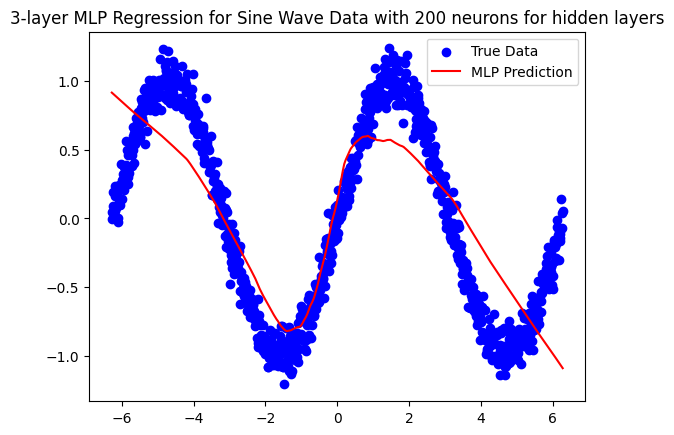

In [ ]:
# Initialize weights and biases
def initialize_parameters(input_size, hidden_size, output_size, num_hidden_layers = 2):
    parameters = {}
    parameters['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(1 / input_size)
    parameters['b1'] = np.random.randn(1, hidden_size)

    for i in range(2, num_hidden_layers + 1):
        parameters[f'W{i}'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(1 / hidden_size)
        parameters[f'b{i}'] = np.random.randn(1, hidden_size)

    parameters[f'W{num_hidden_layers + 1}'] = np.random.randn(hidden_size, output_size) * np.sqrt(1 / hidden_size)
    parameters[f'b{num_hidden_layers + 1}'] = np.random.randn(1, output_size)

    return parameters

# Forward pass
def forward(X, parameters, num_hidden_layers = 2):
    cache = {}

    A = X

    for i in range(1, num_hidden_layers + 1):
        Z = np.dot(A, parameters[f'W{i}']) + parameters[f'b{i}']
        A = relu(Z)
        cache[f'Z{i}'] = Z
        cache[f'A{i}'] = A

    # Output layer (linear function)
    Z_output = np.dot(A, parameters[f'W{num_hidden_layers + 1}']) + parameters[f'b{num_hidden_layers + 1}']
    cache[f'Z{num_hidden_layers + 1}'] = Z_output

    return Z_output, cache

# Backward pass (Stochastic Gardient Descent)
def backward(X, y, parameters, cache, velocities, num_hidden_layers = 2, learning_rate = 0.001, momentum = 0.9):
    m = y.size
    grads = {}

    # Gradient of loss w.r.t. output (Z_output)
    dZ_output = mse_loss_derivative(y, cache[f'Z{num_hidden_layers + 1}']) # (m, 1)

    # Gradient w.r.t. W_output and b_output
    grads[f'dW{num_hidden_layers + 1}'] = np.dot(cache[f'A{num_hidden_layers}'].T, dZ_output) / m # (hidden_size, 1)
    grads[f'db{num_hidden_layers + 1}'] = np.sum(dZ_output, axis = 0, keepdims = True) / m # (1, hidden_size)

    # Propagate gradients through the hidden layers
    dA_prev = np.dot(dZ_output, parameters[f'W{num_hidden_layers + 1}'].T) # (m, hidden_size)

    for i in range(num_hidden_layers, 0, -1):
        dZ = dA_prev * relu_derivative(cache[f'Z{i}']) # Apply ReLU derivative
        grads[f'dW{i}'] = np.dot((X if i == 1 else cache[f'A{i - 1}']).T, dZ) / m
        grads[f'db{i}'] = np.sum(dZ, axis = 0, keepdims = True) / m
        if i > 1:
            dA_prev = np.dot(dZ, parameters[f'W{i}'].T)

    for i in range(1, num_hidden_layers + 2):
        velocities[f'W{i}'] = momentum * velocities[f'W{i}'] - learning_rate * grads[f'dW{i}']
        velocities[f'b{i}'] = momentum * velocities[f'b{i}'] - learning_rate * grads[f'db{i}']
        parameters[f'W{i}'] += velocities[f'W{i}']
        parameters[f'b{i}'] += velocities[f'b{i}']

    return parameters, velocities

# Training loop
def train(X, y, hidden_size = 200, epochs = 5000, learning_rate = 0.001, momentum = 0.9):
    input_size = X.shape[1]
    output_size = 1 # We want 1 output (regression)
    num_hidden_layers = 2

    # Initialize parameters
    parameters = initialize_parameters(input_size, hidden_size, output_size, num_hidden_layers)
    velocities = {k: np.zeros_like(v) for k, v in parameters.items()}

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        y_pred, cache = forward(X, parameters, num_hidden_layers)

        # Compute loss
        loss = mse_loss(y, y_pred)

        # Backward pass and update parameters
        parameters, velocities = backward(X, y, parameters, cache, velocities, num_hidden_layers, learning_rate, momentum)

        # Print loss every 100 epochs
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return parameters

# Prediction
def predict(X, parameters, num_hidden_layers = 2):
    y_pred, _ = forward(X, parameters, num_hidden_layers)
    return y_pred

# Train the MLP
parameters = train(X, y, hidden_size = 200, epochs = 10000, learning_rate = 0.001)

# Predict on the training data
y_pred = predict(X, parameters)

# Plot the results
plt.scatter(X, y, label='True Data', color='blue')
plt.plot(X, y_pred, label='MLP Prediction', color='red')
plt.legend()
plt.title('3-layer MLP Regression for Sine Wave Data with 200 neurons for hidden layers')
plt.show()

## Nhận xét:
- Cả 2 mô hình đều bẻ đường dự đoán gần với tập dữ liệu, thời gian train nhanh.
- Mô hình 100 neurons chưa bẻ đường dự đoán tốt, một số đoạn vẫn còn xa tập dữ liệu hoặc vẫn còn là đường thẳng.
- Mô hình 200 neurons bẻ đường dự đoán tốt hơn 100 neuron, nhưng vẫn còn một số đoạn thẳng và chưa thực sự sát với tập dữ liệu.